## Step - 1 - Data Curation

Using the 2 different api endpoints made publicly available, we get the links for accessing the data.
The links when used in the requests.get package, returns a response that can be saved as a Json file.
The five variables below, store the response for 5 queries, each containing pageview and pagecount data from the mobile or desktop site, on a monthly basis.

#### Import data from the api endpoints using requests package 

In [4]:
import requests
pc_desk_mon_all = requests.get("https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia/desktop-site/monthly/2008010100/2016080100")
pc_mob_mon_all = requests.get("https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia/mobile-site/monthly/2008010100/2016080100")
pv_desk_mon_all = requests.get("https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/desktop/user/monthly/2015070100/2017100100")
pv_mobw_mon_all = requests.get("https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/mobile-web/user/monthly/2015070100/2017100100")
pv_moba_mon_all = requests.get("https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/mobile-app/user/monthly/2015070100/2017100100")
# only user data was downloaded from the pageview api, excluding all spider data. 

#### Check the status codes for each of the requests, if they are successful they should be equal to 200

In [7]:
print(pc_desk_mon_all.status_code, pc_mob_mon_all.status_code, pv_desk_mon_all.status_code, pv_mobw_mon_all.status_code , pv_moba_mon_all.status_code)


200 200 200 200 200


#### Save the raw data to 5 files using json.dump function as per the naming conventions.

In [9]:
# save the raw data 
import json
with open('pagecounts_desktop-site_200801-201607.json','w') as outfile:
    json.dump(pc_desk_mon_all.json(), outfile)
with open('pagecounts_mobile-site_200801-201607.json','w') as outfile:
    json.dump(pc_mob_mon_all.json(), outfile)
# the location of the file write will be the same as this notebook
with open('pageviews_desktop-site_201507-201709.json','w') as outfile:
    json.dump(pv_desk_mon_all.json(), outfile)
with open('pageviews_mobile-app-site_201507-201709.json','w') as outfile:
    json.dump(pv_moba_mon_all.json(), outfile)
with open('pageviews_mobile-web-site_201507-201709.json','w') as outfile:
    json.dump(pv_mobw_mon_all.json(), outfile)

## Step - 2 - Data Processing

We will perform a series of processing steps on these data files in order to prepare them for analysis. 
The key steps are outline below
1. Combine the monthly values for mobile app and mobile web from the Pageviews api
2. Separate the timestamp values into 2 fields for month and year for all 5 data files.
3. Replace all the Nan values in the data with 0.
4. Finally, merge all the data into a single csv file that will be used for data analysis.

#### Create a pandas dataframe for pageviews data, by summing up the monthly values for mobile app and web

In [166]:
# Creating a pandas dataframe for pageviews data
import pandas as pd
import numpy as np
# variables for store the json data
pv_mob_a = pv_moba_mon_all.json()
pv_mob_w = pv_mobw_mon_all.json()
pv_desk = pv_desk_mon_all.json()
# empty lists to merge data
pageview_a = []
pageview_w = []
pageview_desk = []
timestamp_pv = []
# get the values of timestamp and no of views in a separate list
i = 0
for i in range(len(pv_mob_a['items'])):
    pageview_a.append(pv_mob_a['items'][i]['views'])
    pageview_w.append(pv_mob_w['items'][i]['views'])
    timestamp_pv.append(pv_mob_w['items'][i]['timestamp'])
    pageview_desk.append(pv_desk['items'][i]['views'])
    i += 1
# sum the values for views from mobile app and web
pageview_mob_t = [pageview_a[i]+pageview_w[i] for i in range(len(pageview_a))]
# extract year from the timestamp
year = [timestamp_pv[i][0:4] for i in range(len(timestamp_pv))]
# extract month from the timestamp
month = [timestamp_pv[i][4:6] for i in range(len(timestamp_pv))]
# create a new dataframe with the new fields as columns
pageview_df = pd.DataFrame(np.column_stack([year, month, pageview_mob_t, pageview_desk]), 
              columns=['year', 'month', 'pageview_mobile_views', 'pageview_desktop_views'])
pageview_df[['year', 'month', 'pageview_mobile_views', 'pageview_desktop_views']] = pageview_df[['year', 'month', 'pageview_mobile_views', 'pageview_desktop_views']].apply(pd.to_numeric)
pageview_df['pageview_all_views'] = pageview_df['pageview_mobile_views'] + pageview_df['pageview_desktop_views']

In [167]:
# creating a pandas dataframe for pagecount mobile data
pc_mob = pc_mob_mon_all.json()
timestamp_pc_mob = []
pagecount_mob = []
j = 0
# get the values of timestamp and no of views in a separate list
for j in range(len(pc_mob['items'])):
    pagecount_mob.append(pc_mob['items'][j]['count'])
    timestamp_pc_mob.append(pc_mob['items'][j]['timestamp'])
    j += 1
# extract year from the timestamp   
pc_m_year = [timestamp_pc_mob[i][0:4] for i in range(len(timestamp_pc_mob))]
# extract month from the timestamp
pc_m_month = [timestamp_pc_mob[i][4:6] for i in range(len(timestamp_pc_mob))]
# create a new dataframe with the new fields as columns
pagecount_df_mob = pd.DataFrame(np.column_stack([pc_m_year, pc_m_month, pagecount_mob]), 
                   columns=['year', 'month', 'pagecount_mobile_views'])
pagecount_df_mob[['year', 'month', 'pagecount_mobile_views']] = pagecount_df_mob[['year', 'month', 'pagecount_mobile_views']].apply(pd.to_numeric)


In [183]:
# creating a pandas dataframe for pagecount desktop data
pc_desk = pc_desk_mon_all.json()
timestamp_pc_desk = []
pagecount_desk = []
j = 0
# get the values of timestamp and no of views in a separate list
for j in range(len(pc_desk['items'])):
    pagecount_desk.append(pc_desk['items'][j]['count'])
    timestamp_pc_desk.append(pc_desk['items'][j]['timestamp'])
    j += 1
# extract year from the timestamp
pc_d_year = [timestamp_pc_desk[i][0:4] for i in range(len(timestamp_pc_desk))]
# extract month from the timestamp
pc_d_month = [timestamp_pc_desk[i][4:6] for i in range(len(timestamp_pc_desk))]
pagecount_df_desk = pd.DataFrame(np.column_stack([pc_d_year, pc_d_month, pagecount_desk]), 
                   columns=['year', 'month', 'pagecount_desktop_views'])
pagecount_df_desk[['year', 'month', 'pagecount_desktop_views']] = pagecount_df_desk[['year', 'month', 'pagecount_desktop_views']].apply(pd.to_numeric)
# combining both the pagecount dataframes into one and replacing the empty cells with 0
pagecount_df = pagecount_df_desk.merge(pagecount_df_mob, how='left', on=['year','month'])
# replace all the NaN values with 0
pagecount_df['pagecount_mobile_views'].fillna(0, inplace=True)
pagecount_df.pagecount_mobile_views = pagecount_df.pagecount_mobile_views.astype(int)
# calculating the sum of desktop and mobile views and adding a new column to the dataframe
pagecount_df['pagecount_all_views'] = pagecount_df['pagecount_desktop_views'] + pagecount_df['pagecount_mobile_views']

#### Merge the data from the different dataframes into a single dataframe. The outer join was used in this case since we need all the keys from tables on both sides of the join.

In [318]:
# Merging the pagecount and pageviews dataframe on columns month and year to create the final dataframe
wikipedia_df = pagecount_df.merge(pageview_df,how='outer', on=['year','month'])
# replace all the NaN values with 0
wikipedia_df['pageview_mobile_views'].fillna(0, inplace=True)
wikipedia_df['pageview_desktop_views'].fillna(0, inplace=True)
wikipedia_df['pageview_all_views'].fillna(0, inplace=True)
wikipedia_df['pagecount_mobile_views'].fillna(0, inplace=True)
wikipedia_df['pagecount_desktop_views'].fillna(0, inplace=True)
wikipedia_df['pagecount_all_views'].fillna(0, inplace=True)
# convert all the fields to type integer
wikipedia_df.pageview_mobile_views = wikipedia_df.pageview_mobile_views.astype(int)
wikipedia_df.pageview_desktop_views = wikipedia_df.pageview_desktop_views.astype(int)
wikipedia_df.pageview_all_views = wikipedia_df.pageview_all_views.astype(int)
wikipedia_df.pagecount_mobile_views = wikipedia_df.pagecount_mobile_views.astype(int)
wikipedia_df.pagecount_desktop_views = wikipedia_df.pagecount_desktop_views.astype(int)
wikipedia_df.pagecount_all_views = wikipedia_df.pagecount_all_views.astype(int)

#### Save the file to a csv as per the naming conventions. The dataframe.to_csv package is useful in this case

In [200]:
# saving this dataframe to the final csv data file
wikipedia_df.to_csv('en-wikipedia_traffic_200801-201709.csv',index=False)

## Step - 3 - Analysis


#### The data needs to be visualized using a timeseries plot, and we use the dataframe.plot function to achieve this

In [319]:
# Plot a time series using the data from the final dataset created in step - 2 above
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
# create a date column by combining the year and month columns
wikipedia_df['date'] = wikipedia_df['year'].astype(str) + wikipedia_df['month'].astype(str)
wikipedia_df['date'] = pd.to_datetime(wikipedia_df['date'],format='%Y%m')
del wikipedia_df['month']
del wikipedia_df['year']
# modified the 0 data , so they wouldnt be plotted on the graph
cols = ["pagecount_desktop_views","pagecount_mobile_views","pagecount_all_views","pageview_mobile_views","pageview_desktop_views","pageview_all_views"]
wikipedia_df[cols] = wikipedia_df[cols].replace({0:np.nan, 0:np.nan})



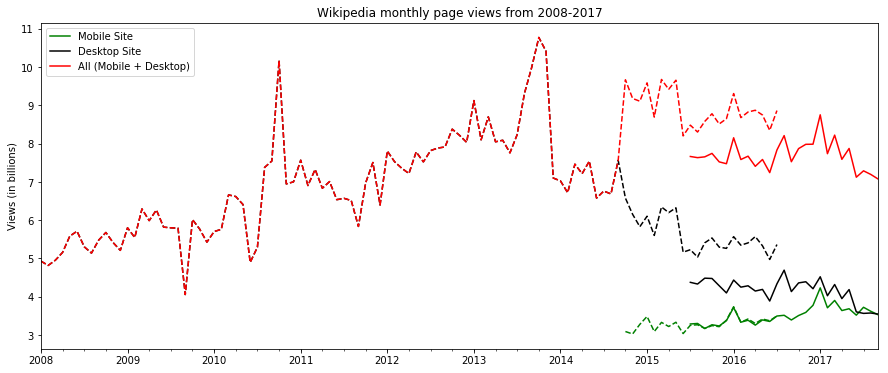

In [330]:
# Using the dataframe.plot method, specify the fig siz, title, and color and style of lines to be used
ax = wikipedia_df.plot(x='date',title='Wikipedia monthly page views from 2008-2017', sort_columns=True, figsize=(15,6), style=['k--','g--','r--', 'g', 'k', 'r'])
plt.ylabel('Views (in billions)')
plt.xlabel('')
# format the y axis to display in billions of views
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, pos: '{0:g}'.format(y/1000000000)))
# overide the default legend, to customize it as per the requirement
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines[3:], ['Mobile Site','Desktop Site','All (Mobile + Desktop)'], loc=2)
# save the plot 
plt.savefig('wikipedia_page_views_viz.png')

Analyzing the plot, we can see a somewhat linear increase in the number of views from 2008 till Sep-2014. 
Once the mobile data(green dotted line) starts being recorded, there is a significant decline in the number of views on the desktop site(black dotted line). The total page views also sees a drop after hitting a peak somewhere around mid 2013, I suspect this is due to an emergence of alternative websites that act as competitors to wikipedia.